In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from dtaidistance import dtw
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np

In [3]:
public = pd.read_csv('./ready/public_media_vaccine.csv', encoding='utf-8-sig')
civil = pd.read_csv('./ready/civil_platform_vaccine.csv', encoding='utf-8-sig')

emotion_groups_ekman = {
    'Happiness': ['joy', 'amusement', 'excitement', 'pride', 'gratitude', 'relief', 'love', 'caring'],
    'Sadness': ['sadness', 'disappointment', 'remorse', 'grief'],
    'Anger': ['anger', 'annoyance', 'disapproval'],
    'Fear': ['fear', 'nervousness'],
    'Disgust': ['disgust', 'embarrassment'],
    'Surprise': ['surprise', 'realization', 'confusion'],
}

def process_platform_emotions(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce').dt.tz_localize(None)
    df = df.dropna(subset=[date_col])
    df['week'] = df[date_col].dt.to_period('W').apply(lambda r: r.start_time)

    for group, emotions in emotion_groups_ekman.items():
        df[group] = df[emotions].mean(axis=1)

    weekly_df = df.groupby('week')[list(emotion_groups_ekman.keys())].mean().reset_index()
    return weekly_df

weekly_public = process_platform_emotions(public, 'pub_date')
weekly_civil = process_platform_emotions(civil, 'pub_date')


[Smoothed + Normalized DTW Distance Results]
     emotion  dtw_distance
0  Happiness     12.043366
1    Sadness     10.045961
2      Anger      9.317764
3       Fear     10.980433
4    Disgust     10.681793
5   Surprise     12.106128


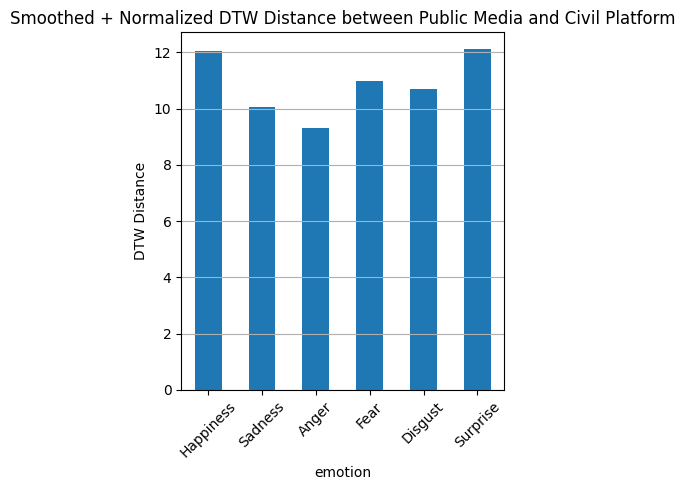

In [4]:
# 감정군 정의
emotion_groups = ['Happiness', 'Sadness', 'Anger', 'Fear', 'Disgust', 'Surprise']

# 1. Smoothing 함수 (centered moving average)
def smooth_df(df, emotions, window=4):
    df_smoothed = df.copy()
    for emotion in emotions:
        df_smoothed[emotion] = df[emotion].rolling(window=window, center=True).mean()
    return df_smoothed.dropna()

# 2. Z-score 정규화 함수
def zscore_normalize(df, columns):
    df_norm = df.copy()
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        df_norm[col] = (df[col] - mean) / std if std != 0 else 0
    return df_norm

# 3. DTW 계산 함수
def compute_dtw_normalized(public_df, civil_df, emotions):
    results = []
    for emotion in emotions:
        merged = pd.merge(
            public_df[['week', emotion]],
            civil_df[['week', emotion]],
            on='week',
            suffixes=('_public', '_civil')
        )
        if len(merged) < 5:
            continue
        series1 = merged[f'{emotion}_public'].to_numpy()
        series2 = merged[f'{emotion}_civil'].to_numpy()
        distance = dtw.distance(series1, series2)
        results.append({'emotion': emotion, 'dtw_distance': distance})
    return pd.DataFrame(results)

# 4. Public + Civil smoothing
weekly_public_smooth = smooth_df(weekly_public, emotion_groups)
weekly_civil_smooth = smooth_df(weekly_civil, emotion_groups)

# 5. 정규화
weekly_public_smooth_norm = zscore_normalize(weekly_public_smooth, emotion_groups)
weekly_civil_smooth_norm = zscore_normalize(weekly_civil_smooth, emotion_groups)

# 6. DTW 실행
dtw_smooth_results = compute_dtw_normalized(
    weekly_public_smooth_norm,
    weekly_civil_smooth_norm,
    emotion_groups
)

# 7. 출력 및 시각화
print("\n[Smoothed + Normalized DTW Distance Results]")
print(dtw_smooth_results)

dtw_smooth_results.set_index('emotion').plot(kind='bar', legend=False, figsize=(4, 5))
plt.title('Smoothed + Normalized DTW Distance between Public Media and Civil Platform')
plt.ylabel('DTW Distance')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

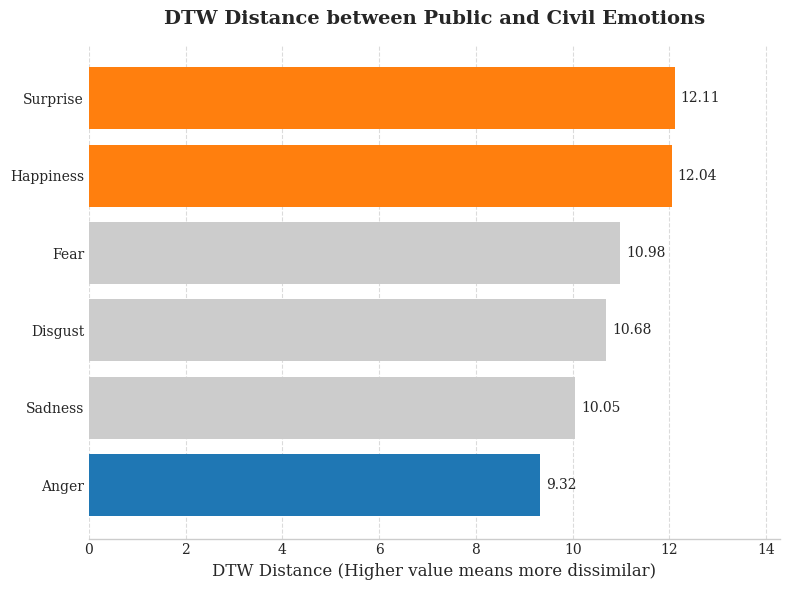

In [5]:
# --- 7. DTW 결과 시각화 개선 ---

# DTW 거리 기준으로 데이터프레임을 내림차순 정렬합니다.
df_sorted = dtw_smooth_results.sort_values(by='dtw_distance', ascending=True)

# 시각화 스타일을 설정합니다.
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(8, 6))

# 최솟값과 최댓값을 강조하기 위한 색상 리스트를 생성합니다.
min_dist = df_sorted['dtw_distance'].min()
max_dist = df_sorted['dtw_distance'].max()
highlight_threshold = max_dist * 0.95 # 상위 그룹 강조 기준

colors = []
for val in df_sorted['dtw_distance']:
    if val == min_dist:
        colors.append('#1f77b4')  # 최솟값 (가장 유사)
    elif val >= highlight_threshold:
        colors.append('#ff7f0e')  # 상위 그룹 (가장 상이)
    else:
        colors.append('#cccccc')  # 나머지
# 수평 막대그래프를 그립니다.
bars = ax.barh(df_sorted['emotion'], df_sorted['dtw_distance'], color=colors)

# 막대 옆에 정확한 DTW 거리 값을 텍스트로 추가합니다.
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + (ax.get_xlim()[1] * 0.01) # 막대 오른쪽에 살짝 여유 공간
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
            va='center', fontsize=10)

# 제목 및 라벨 설정
ax.set_title('DTW Distance between Public and Civil Emotions', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('DTW Distance (Higher value means more dissimilar)', fontsize=12)
ax.set_ylabel('') # Y축 라벨은 불필요하므로 제거

# 불필요한 테두리(spines)를 제거하여 깔끔하게 만듭니다.
ax.spines[['top', 'right', 'left']].set_visible(False)
# Y축의 눈금선은 제거하고 X축 눈금선만 은은하게 표시합니다.
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.grid(axis='y', linestyle='')

# X축 범위를 조정하여 텍스트 라벨이 잘리지 않게 합니다.
ax.set_xlim(0, df_sorted['dtw_distance'].max() * 1.18)

# 레이아웃을 최적화합니다.
plt.tight_layout()
plt.savefig('Figure4.svg', dpi=300, bbox_inches='tight')
plt.savefig('Figure4.png', dpi=300, bbox_inches='tight')
plt.show()